In [1]:
# Import necessary libraries
import torch.cuda as torch_cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [2]:
print('===VERIFY GPU===')
print('CUDA IS AVAILABLE:', torch_cuda.is_available())
print('DEVICE COUNT:', torch_cuda.device_count())
print('DEVICE NAME:', torch_cuda.get_device_name(0))

# If CUDA is available, print GPU details
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch_cuda.device_count()}")
    print(f"GPU Name: {torch_cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch_cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch_cuda.memory_reserved(0)} bytes")

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch_cuda.is_available() else 'cpu')

===VERIFY GPU===
CUDA IS AVAILABLE: True
DEVICE COUNT: 1
DEVICE NAME: NVIDIA RTX A4000
Number of GPUs: 1
GPU Name: NVIDIA RTX A4000
GPU Memory Allocated: 0 bytes
GPU Memory Cached: 0 bytes


## Dataset

In [ ]:
# Define hyperparameters
batch_size = 16

# Define transformations: Convert to tensor and normalize
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

svhn_trainset = datasets.SVHN(
    root='../Data/SVHN',
    split='train',
    download=True,
    transform=transformations
)

svhn_testset = datasets.SVHN(
    root='../Data/SVHN',
    split='test',
    download=True,
    transform=transformations
)

trainloader = DataLoader(
    svhn_trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = DataLoader(
    svhn_testset,
    batch_size=batch_size,
    shuffle=False,
)

In [4]:
trainloader.dataset.data[0].shape

(3, 32, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.8352941].


TRAIN SET LENGTH: 73257
TEST SET LENGTH: 26032


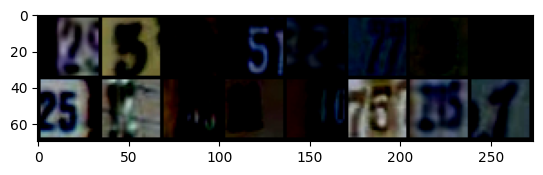

In [ ]:
print('TRAIN SET LENGTH:', len(svhn_trainset))
print('TEST SET LENGTH:', len(svhn_testset))

def imshow(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='viridis')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

## Model

### Parameters

In [6]:
learning_rate = 0.01
learning_decay = 10**-9
epochs = 100

# Classes for MNIST digits
classes = (0,1,2,3,4,5,6,7,8,9)

### Definition

In [7]:
# Define a multi-layer perceptron (MLP) model
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        # Flatten layer to convert 32x32x3 images into 3072-dim vector
        self.flat = nn.Flatten()

        # Define linear layers
        self.input_layer = nn.Linear(3072, 1000)
        self.hidden_layer1 = nn.Linear(1000, 1000)
        self.hidden_layer2 = nn.Linear(1000, 1000)
        self.hidden_layer3 = nn.Linear(1000, 1000)
        self.hidden_layer4 = nn.Linear(1000, 1000)
        self.out = nn.Linear(1000, 10)

        # Define dropout layers
        self.dropout_layer1 = nn.Dropout(p=0.2)
        self.dropout_layer2 = nn.Dropout(p=0.3)
        self.dropout_layer3 = nn.Dropout(p=0.4)
        self.dropout_layer4 = nn.Dropout(p=0.5)

    def forward(self, x):
        # Flatten the image into a 3072-dim vector
        x = x.reshape(-1, 3072)

        # Pass through layers with ReLU activation and dropout
        x = F.relu(self.input_layer(x))
        x = self.dropout_layer1(F.relu(self.hidden_layer1(x)))
        x = self.dropout_layer2(F.relu(self.hidden_layer2(x)))
        x = self.dropout_layer3(F.relu(self.hidden_layer3(x)))
        x = self.dropout_layer4(F.relu(self.hidden_layer4(x)))

        # IMPORTANT FIX: Do not apply softmax here.
        # CrossEntropyLoss expects raw logits.
        x = self.out(x)

        return x  # Return raw logits

# Instantiate and move model to the selected device
mlp = MLP().to(device)

loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss expects raw logits
optimizer = optim.SGD(mlp.parameters(), lr=learning_rate,
                      weight_decay=learning_decay)


### Test and Train Functions

In [10]:
def train(epoch):

    mlp.train()
    for batch_idx, (data, target) in enumerate(trainloader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = mlp(data)


        loss = loss_function(output, target)

        loss.backward()

        optimizer.step()

        if batch_idx % 25 == 0:
            print('Train Epoch: {:>3}\t[{:>5}/{:>5} ({:>3.0f}%)]\tLoss: {:>7.6f}'.format(
                epoch + 1, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))


def test():
    mlp.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in testloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = mlp(data)

            # Compute loss and accumulate
            test_loss += loss_function(output, target).item()

            # Get predicted classes
            pred = output.argmax(dim=1, keepdim=True)

            # Count how many predictions are correct
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average loss over the entire test set
    test_loss /= len(testloader)

    # Print test performance
    print('\nTest set: Average loss: {:>10.4f}, Accuracy: {:>5}/{:>5} ({:>3.2f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))

### Training

In [9]:
# Run the training and testing for defined epochs
for epoch in range(epochs):
    train(epoch)
    test()

Train Epoch:   1	[    0/73257 (  0%)]	Loss: 2.305136
Train Epoch:   1	[  400/73257 (  1%)]	Loss: 2.293413
Train Epoch:   1	[  800/73257 (  1%)]	Loss: 2.301846
Train Epoch:   1	[ 1200/73257 (  2%)]	Loss: 2.291678
Train Epoch:   1	[ 1600/73257 (  2%)]	Loss: 2.284333
Train Epoch:   1	[ 2000/73257 (  3%)]	Loss: 2.304270
Train Epoch:   1	[ 2400/73257 (  3%)]	Loss: 2.269404
Train Epoch:   1	[ 2800/73257 (  4%)]	Loss: 2.279288
Train Epoch:   1	[ 3200/73257 (  4%)]	Loss: 2.286619
Train Epoch:   1	[ 3600/73257 (  5%)]	Loss: 2.279299
Train Epoch:   1	[ 4000/73257 (  5%)]	Loss: 2.250630
Train Epoch:   1	[ 4400/73257 (  6%)]	Loss: 2.313577
Train Epoch:   1	[ 4800/73257 (  7%)]	Loss: 2.212270
Train Epoch:   1	[ 5200/73257 (  7%)]	Loss: 2.215481
Train Epoch:   1	[ 5600/73257 (  8%)]	Loss: 2.269882
Train Epoch:   1	[ 6000/73257 (  8%)]	Loss: 2.267621
Train Epoch:   1	[ 6400/73257 (  9%)]	Loss: 2.308311
Train Epoch:   1	[ 6800/73257 (  9%)]	Loss: 2.252063
Train Epoch:   1	[ 7200/73257 ( 10%)]	Loss: 2.

In [11]:
test()


Test set: Average loss:     0.9817, Accuracy: 22232/26032 (85.40%)



In [12]:
torch.save(mlp.state_dict(), '../Saved/SVHN_MLP_TRAINED.pt')